In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import random
from PIL import Image, ImageDraw, ImageFont

from glob import glob
import os
import shutil
from copy import deepcopy
from tqdm.notebook import tqdm

In [2]:
os.getcwd(), os.listdir(os.getcwd())

('C:\\Users\\User\\Desktop\\Pice\\Work\\ConnectedTech\\UTAC_OCR\\Data_Augmentation\\pipeline_exp1',
 ['.ipynb_checkpoints',
  'background_images',
  'checkpoints',
  'font_families',
  'generated_chars',
  'gen_text.ipynb',
  'inference_cyclegan.ipynb',
  'mask_created',
  'results'])

In [25]:
config = {}
WORK_DIR = os.getcwd()

# stylized characters creation
config["fake_image_dir"] = os.path.join(WORK_DIR, "gen_font", "fake_images")
config["mask_image_dir"] = os.path.join(WORK_DIR, "gen_font", "mask_images")
config["mask_created_dir"] = os.path.join(WORK_DIR, "gen_font", "mask_created")
config["mask_created_save_dir"] = os.path.join(WORK_DIR, "mask_created", "testB")

config["generated_chars_dir"] = os.path.join(WORK_DIR, "gen_font", "BLAHHHHH")

config["exp_name"] = "font_generation_exp2"
config["font_family_path"] = "../../Font_Style_Generation/fonts/Unison-Pro-Light.ttf"
config["mask_size"] = 256
config["font_size"] = 200
config["right_padding"] = 20
config["bottom_padding"] = 30
config["transform_prob"] = 0.3

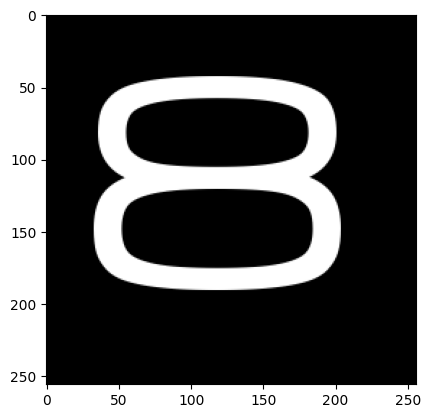

In [17]:
char = "8"
mask_w, mask_h = (config["mask_size"], config["mask_size"])
image = Image.new("RGB", (mask_w, mask_h), "black")
font = ImageFont.truetype(config["font_family_path"], config["font_size"])

draw = ImageDraw.Draw(image)
_, _, w, h = draw.textbbox((0, 0), char, font=font)
c_w, c_h = (mask_w-w)/2 - config['right_padding'], (mask_h-h)/2 - config['bottom_padding']
draw.text((c_w, c_h), char, fill="white", font=font)  # draw text mask at CENTER

image = np.array(image)
plt.imshow(image)

In [12]:
import sys

# to import everything from cyclegan !!
sys.path.append("../../Background_Removal/pytorch-CycleGAN-and-pix2pix/")

In [14]:
from options.test_options import TestOptions

In [16]:
import os
from data.base_dataset import BaseDataset, get_transform
from data.image_folder import make_dataset
from PIL import Image
import random
# pice
import albumentations as A

# not from paths, but from image arrays
class MyCustomDataset(BaseDataset):
    def __init__(self, opt):
        """Initialize this dataset class.

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseDataset.__init__(self, opt)
        self.A_image_arrays = []
        self.B_image_arrays = []
        self.A_size = len(self.A_image_arrays)
        self.B_size = len(self.B_image_arrays)
        
        btoA = self.opt.direction == 'BtoA'
        input_nc = self.opt.output_nc if btoA else self.opt.input_nc
        output_nc = self.opt.input_nc if btoA else self.opt.output_nc
        
        # pice's implementation
        self.albumentation_A = A.Compose([
            A.RandomBrightnessContrast(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
        ])
        self.albumentation_B = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
        ])
        
        self.transform_A = get_transform(self.opt, grayscale=(input_nc == 1), albumentation_transforms=self.albumentation_A, domain="A")
        self.transform_B = get_transform(self.opt, grayscale=(output_nc == 1), albumentation_transforms=self.albumentation_B, domain="B")

    def __getitem__(self, index):
        A_img = self.A_image_arrays[index % self.A_size]  # make sure index is within then range
        if self.opt.serial_batches:   # make sure index is within then range
            index_B = index % self.B_size
        else:   # randomize the index for domain B to avoid fixed pairs.
            index_B = random.randint(0, self.B_size - 1)
        B_img = self.B_image_arrays[index_B]
        
        # apply image transformation
        A = self.transform_A(A_img)
        B = self.transform_B(B_img)

        return {'A': A, 'B': B}   #, 'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        return max(self.A_size, self.B_size)

In [ ]:
os.system(f"python test.py --dataroot None --direction BtoA --checkpoints_dir ./checkpoints/ --name {config['exp_name']} --results_dir {config['generated_chars_dir']} --preprocess scale_width_and_crop --load_size {config['mask_size']} --crop_size {config['mask_size']} --num_test 100 --model test --no_dropout")

In [28]:
import subprocess
 
command = f"python test.py --dataroot None --direction BtoA --checkpoints_dir ./checkpoints/ --name {config['exp_name']} --results_dir {config['generated_chars_dir']} --preprocess scale_width_and_crop --load_size {config['mask_size']} --crop_size {config['mask_size']} --num_test 100 --model test --no_dropout"

result = subprocess.check_output(command, shell=True, text=True)
print(result)

CalledProcessError: Command 'python test.py --dataroot None --direction BtoA --checkpoints_dir ./checkpoints/ --name font_generation_exp2 --results_dir C:\Users\User\Desktop\Pice\Work\ConnectedTech\UTAC_OCR\Data_Augmentation\pipeline_exp1\gen_font\BLAHHHHH --preprocess scale_width_and_crop --load_size 256 --crop_size 256 --num_test 100 --model test --no_dropout' returned non-zero exit status 1.

In [23]:
opt = TestOptions().parse()  # get test options
# # pice's part
# opt.eval = True
# opt.dataroot = "../../Background_Removal/pytorch-CycleGAN-and-pix2pix/datasets/2401UTAC_jpg_cropped"

# opt.num_threads = 0   # test code only supports num_threads = 0
# opt.batch_size = 1    # test code only supports batch_size = 1
# opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
# opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
# opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.

usage: ipykernel_launcher.py [-h] --dataroot DATAROOT [--name NAME] [--gpu_ids GPU_IDS]
                             [--checkpoints_dir CHECKPOINTS_DIR] [--model MODEL] [--input_nc INPUT_NC]
                             [--output_nc OUTPUT_NC] [--ngf NGF] [--ndf NDF] [--netD NETD] [--netG NETG]
                             [--n_layers_D N_LAYERS_D] [--norm NORM] [--init_type INIT_TYPE] [--init_gain INIT_GAIN]
                             [--no_dropout] [--dataset_mode DATASET_MODE] [--direction DIRECTION] [--serial_batches]
                             [--num_threads NUM_THREADS] [--batch_size BATCH_SIZE] [--load_size LOAD_SIZE]
                             [--crop_size CROP_SIZE] [--max_dataset_size MAX_DATASET_SIZE] [--preprocess PREPROCESS]
                             [--no_flip] [--display_winsize DISPLAY_WINSIZE] [--epoch EPOCH] [--load_iter LOAD_ITER]
                             [--verbose] [--suffix SUFFIX] [--use_wandb] [--wandb_project_name WANDB_PROJECT_NAME]
              

SystemExit: 2

In [ ]:
albumentation_B = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
        ])
transform_B = get_transform(self.opt, grayscale=(output_nc == 1), albumentation_transforms=self.albumentation_B, domain="B")

data = {'A': [], 'B': }

In [15]:
import os
from options.base_options import BaseOptions
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html


if __name__ == '__main__':
    opt = TestOptions().parse()  # get test options
    opt.num_threads = 0   # test code only supports num_threads = 0
    opt.batch_size = 1    # test code only supports batch_size = 1
    opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
    opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
    opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.

    # pice's part
    opt.eval = True
    opt.dataroot = ""

    # dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
    model = create_model(opt)      # create a model given opt.model and other options
    model.setup(opt)               # regular setup: load and print networks; create schedulers

    # For [CycleGAN]: It should not affect CycleGAN as CycleGAN uses instancenorm without dropout.
    if opt.eval:
        model.eval()
    # Pice - Predict
    model.set_input(data)  # unpack data from data loader
    model.test()           # run inference
    visuals = model.get_current_visuals()  # get image results

usage: ipykernel_launcher.py [-h] --dataroot DATAROOT [--name NAME] [--gpu_ids GPU_IDS]
                             [--checkpoints_dir CHECKPOINTS_DIR] [--model MODEL] [--input_nc INPUT_NC]
                             [--output_nc OUTPUT_NC] [--ngf NGF] [--ndf NDF] [--netD NETD] [--netG NETG]
                             [--n_layers_D N_LAYERS_D] [--norm NORM] [--init_type INIT_TYPE] [--init_gain INIT_GAIN]
                             [--no_dropout] [--dataset_mode DATASET_MODE] [--direction DIRECTION] [--serial_batches]
                             [--num_threads NUM_THREADS] [--batch_size BATCH_SIZE] [--load_size LOAD_SIZE]
                             [--crop_size CROP_SIZE] [--max_dataset_size MAX_DATASET_SIZE] [--preprocess PREPROCESS]
                             [--no_flip] [--display_winsize DISPLAY_WINSIZE] [--epoch EPOCH] [--load_iter LOAD_ITER]
                             [--verbose] [--suffix SUFFIX] [--use_wandb] [--wandb_project_name WANDB_PROJECT_NAME]
              

SystemExit: 2

C:\Users\User\anaconda3\envs\pytorch-CycleGAN-and-pix2pix\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
